<a href="https://colab.research.google.com/github/efkag/Datasets/blob/master/Perfect_Memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#     Perfect Memory Model

In [1]:
from pathlib import Path

p = Path('Datasets/')
if not p.exists():
  ! git clone https://github.com/efkag/Datasets.git
    
! cd Datasets/AntWorld/

Cloning into 'Datasets'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 61010 (delta 0), reused 0 (delta 0), pack-reused 61007
Receiving objects: 100% (61010/61010), 363.92 MiB | 38.15 MiB/s, done.
Resolving deltas: 100% (29/29), done.
Checking out files: 100% (61385/61385), done.


## Imports

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from skimage.measure import compare_ssim as ssim
import math
import cv2
import csv
import pandas as pd
import tensorflow as tf
import tensorflow.keras as tfk
from tensorflow.keras import layers as tfkl
import tensorflow.keras.backend as tfkb
import time


##  Read CSV data files

In [0]:
# Path settings
route_id = '2'
route_id_dir = 'ant1_route' + route_id + '/'
route_dir = 'Datasets/AntWorld/' + route_id_dir
grid_dir = 'Datasets/AntWorld/world5000_grid/'


# Grid Images
data = pd.read_csv(grid_dir + 'world5000_grid.csv',header = 0)
data = data.values
 
# Route
route_data = pd.read_csv(route_dir + 'ant1_route' + route_id + '.csv',header = 0)
route_data = route_data.values

### Organising the data

In [0]:
# Grid data
X = data[:,1] # x location of the image in the world_grid
Y = data [:,0] # y location of the image in the world_grid
img_path = data[:,4] # Name of the image file

# Route data
X_route = route_data[:,1] # x location of the image in the route
Y_route = route_data[:,0] # y location of the image in the route
Heading_route = route_data[:,3] # Image heading
imgs_route_path = route_data[:,4] # Name of the image file

## Importing route image data into Numpy array

In [0]:
max_norm = 1
route_images = []
for i in range (0,len(imgs_route_path)):
    img = cv2.imread(route_dir + imgs_route_path[i][1:], cv2.IMREAD_GRAYSCALE)
    # Normalize 
    img = img * max_norm/img.max()
    route_images.append(img)

## Select the world grid images which are close to the route 

In [0]:
limit = 200 # Maximum distance limit from the Route images
max_norm = 1
X_inlimit = []
Y_inlimit = []
world_grid_imgs = []

# Fetch images from the grid that are located nearby route images.
for i in range(0,len(X),1):
  dist=[]
  for j in range(0,len(X_route),1):
      d = (math.sqrt((X_route[j] - X[i])**2 + (Y_route[j] - Y[i])**2))
      dist.append(d)
  if(min(dist)<limit):
    X_inlimit.append(X[i])
    Y_inlimit.append(Y[i])
    img_dir = grid_dir + img_path[i][1:]
    img = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    # Normalize 
    img = img * max_norm/img.max()
    world_grid_imgs.append(img)

   

# Useful functions

In [0]:
def sample_from_route(maximum, minimum, step):
  """
  Take a sample of coordinates and images from the route
  within the given range
  """
  x_in_range = []
  y_in_range = []
  heading_in_range =[]
  route_images_in_range = []

  for i in range(minimum, maximum, step):
      x_in_range.append(X_route[i])
      y_in_range.append(Y_route[i])
      heading_in_range.append(Heading_route[i])
      route_images_in_range.append(route_images[i])

  return x_in_range, y_in_range, heading_in_range, route_images_in_range

In [0]:
def pol_2cart_headings(headings):
  U = []
  V = []

  for i in range(0,len(headings)):
    U.append(pol2cart(headings[i],1)[0])
    V.append(pol2cart(headings[i],1)[1])
    
  return U, V

### Image Preprocessing

In [0]:
def pre_process(imgs, shape=(200, 200)):
  imgs = [cv2.GaussianBlur(img,(5,5),0) for img in imgs]
  return [cv2.resize(img, shape) for img in imgs]


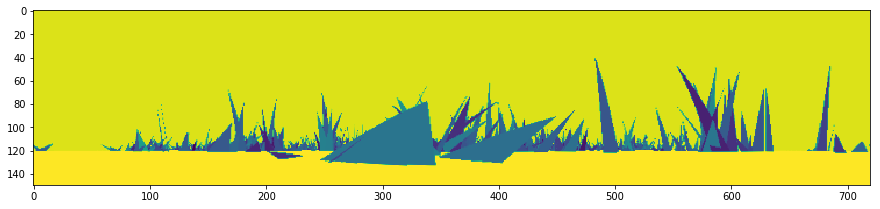

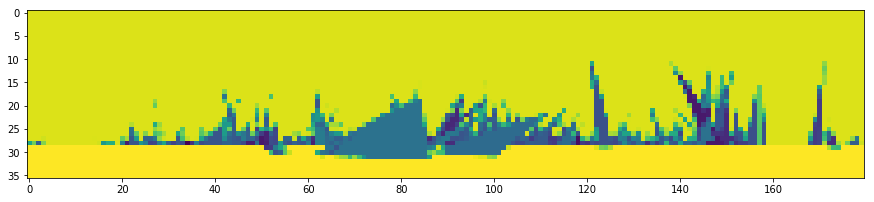

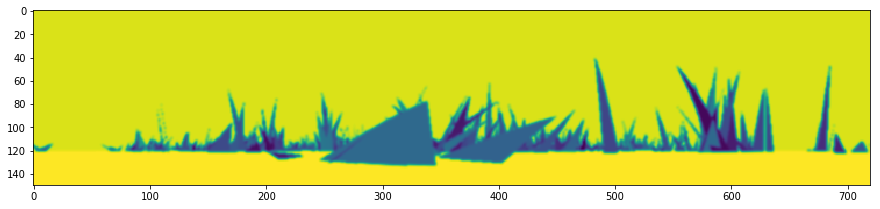

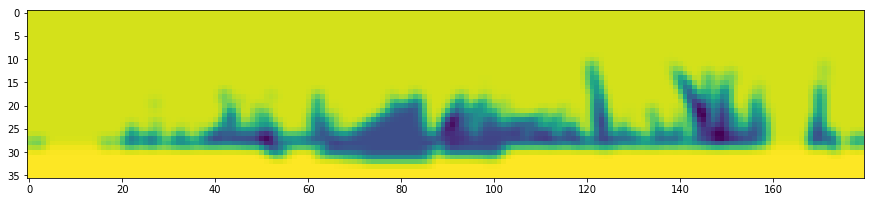

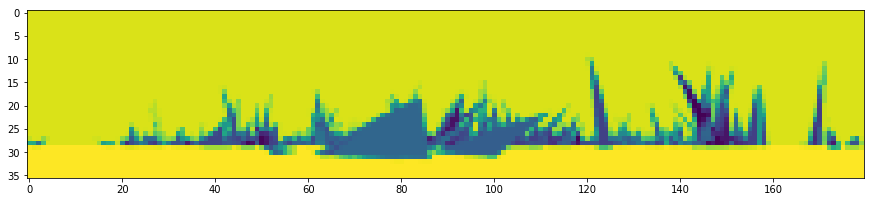

In [12]:
fig =  plt.figure(figsize=(15,10))
plt.imshow(route_images[0])
plt.show()

fig =  plt.figure(figsize=(15,10))
plt.imshow(cv2.resize(route_images[0], (180, 36)))
plt.show()

fig =  plt.figure(figsize=(15,10))
plt.imshow(cv2.GaussianBlur(route_images[0],(5,5),0))
plt.show()

img_temp = cv2.resize(route_images[0], (180, 36))
img_temp = cv2.GaussianBlur(img_temp,(5,5),0)
fig =  plt.figure(figsize=(15,10))
plt.imshow(img_temp)
plt.show()

img_temp = cv2.GaussianBlur(route_images[0],(5,5),0)
img_temp = cv2.resize(img_temp, (180, 36))
fig =  plt.figure(figsize=(15,10))
plt.imshow(img_temp)
plt.show()

### From Degress to Columns / Image Rotation

In [0]:
def rotate(d,image):

  """
  Converts the degrees into columns and rotates the image.

  Parameters
  ---------
  d: the number of degrees the the agent will rotate its view.

  image: An np.array that we want to shift.

  Returns
  -------

  Returns the rotated image.

  """
  if abs(d)>360:
      deg = abs(d) - 360
  if d < 0:
      deg = - deg 
  else:
      deg = d
  num_of_cols = image.shape[1]
  num_of_cols_perdegree = num_of_cols/360
  cols_to_shift = round(deg * num_of_cols_perdegree)
  img1 = image[:,cols_to_shift:num_of_cols]
  img2 = image[:,0 : cols_to_shift]
  return np.concatenate((img1,img2),axis = 1)

In [0]:
def rotate_roll(d,image):

  """Converts the degrees into columns and rotates the image.

  Parameters
  ---------
  d: the number of degrees the the agent will rotate its view.

  image: An np.array that we want to shift.

  Returns
  -------

  This function returns the rotated image.

  """
  if abs(d)>360:
      deg = abs(d) - 360
  if d < 0:
      deg = - deg 
  else:
      deg = d
  num_of_cols = image.shape[1]
  num_of_cols_perdegree = num_of_cols/360
  cols_to_shift = round(deg * num_of_cols_perdegree)
  return np.roll(image, cols_to_shift)

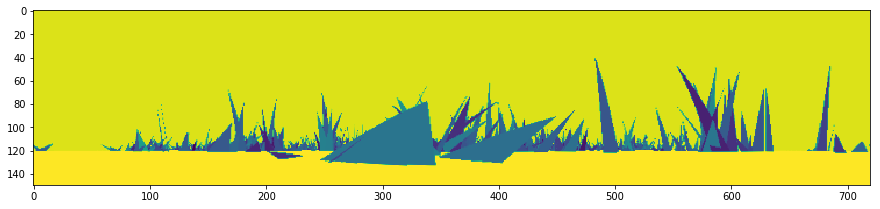

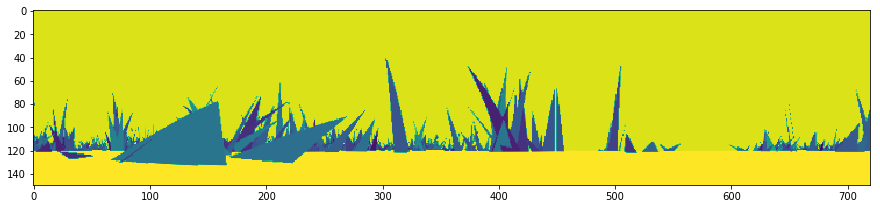

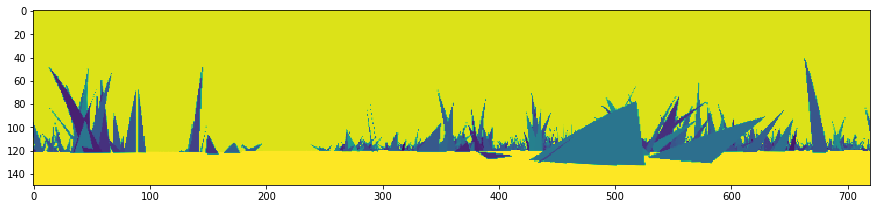

0.21481134659303236


In [0]:
img = route_images[0]
fig =  plt.figure(figsize=(15,10))
plt.imshow(img)
plt.show()


img1 = rotate(90, img)
fig =  plt.figure(figsize=(15,10))
plt.imshow(img1)
plt.show()


img2 = rotate_roll(90, img)
fig =  plt.figure(figsize=(15,10))
plt.imshow(img2)
plt.show()

print(idf(img1, img2))

### Image Difference Function

In [0]:
def idf(img, ref_img):
  """inlimit10
  Image Differencing Function
  """
  return math.sqrt(((ref_img - img)**2).mean())

In [0]:
def pol2cart(theta, r):
    """This function converts the cartesian coordinates into polar coordinates.
    
    Parameters
    ---------
    theta: represents the heading in degrees
    
    r: represens the lenghth of the quiver.
    
    Returns
    -------
    
    This function returns a tuple (float, float) which represents the u and v coordinates 
    of the quiver.
    
    """
    x = r * math.cos(math.radians(theta))
    y = r * math.sin(math.radians(theta))
    return x,y

In [0]:
def plot_map(route_cords=None, grid_cords=None, size=(15,15), save=False, zoom=()):
  fig =  plt.figure(figsize=size)
  fig.suptitle('World Grid', fontsize=16,fontweight='bold')
  plt.xlabel('x coordinates',fontsize=14,fontweight='bold')
  plt.ylabel('y coordinates',fontsize=13,fontweight='bold')
  
  if route_cords: plt.scatter(route_cords[0], route_cords[1] , marker="o", s=1, color='blue')

  if grid_cords: plt.scatter(grid_cords[0], grid_cords[1], marker="*", s=20, color='red')
  plt.imshow(world, zorder=0, extent=[-0.158586*1000 , 10.2428*1000, -0.227704*1000, 10.0896*1000])
  
  if save: fig.savefig('Graph1.jpg')
  if zoom:
      plt.xlim([zoom[0]-2000, zoom[0]+2000])
      plt.ylim([zoom[1]-2000, zoom[1]+2000])
             
  plt.show()

# Plot the world map and the given route.

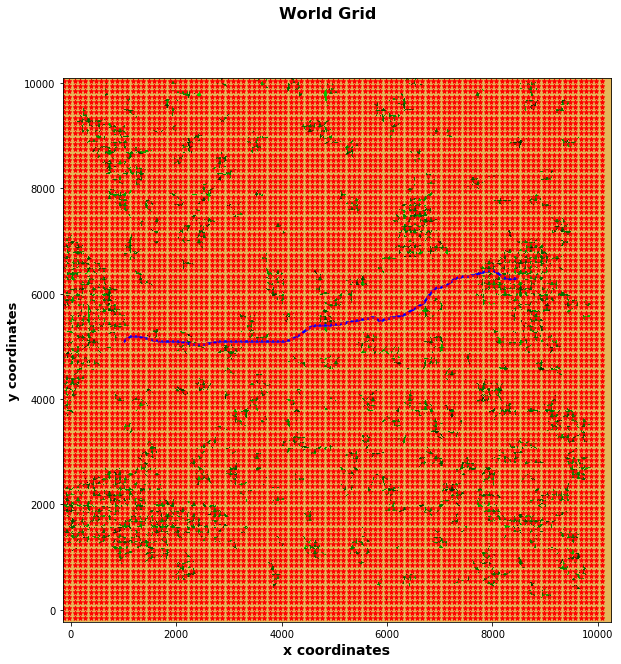

In [32]:
world=mpimg.imread(grid_dir + 'world5000_grid.png')

plot_map([X_route, Y_route], [X, Y], size=(10, 10))

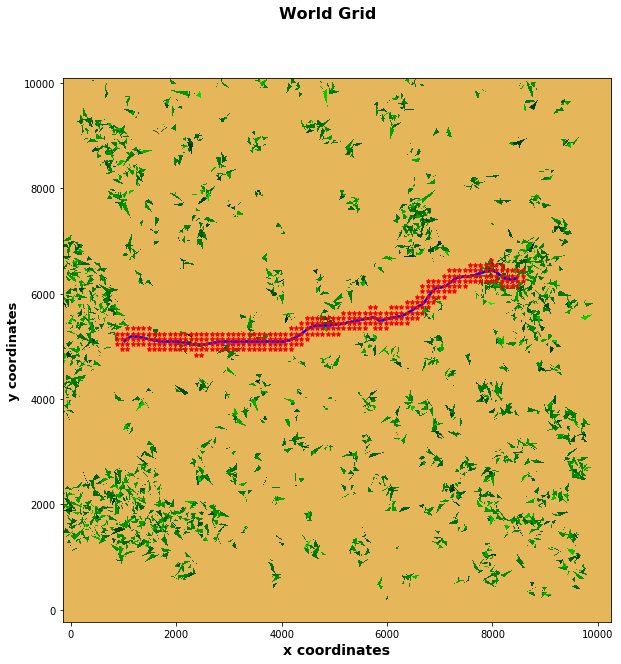

In [36]:
plot_map([X_route, Y_route], [X_inlimit, Y_inlimit], size=(10, 10))


## Zoom in a region of the map given X, Y cords

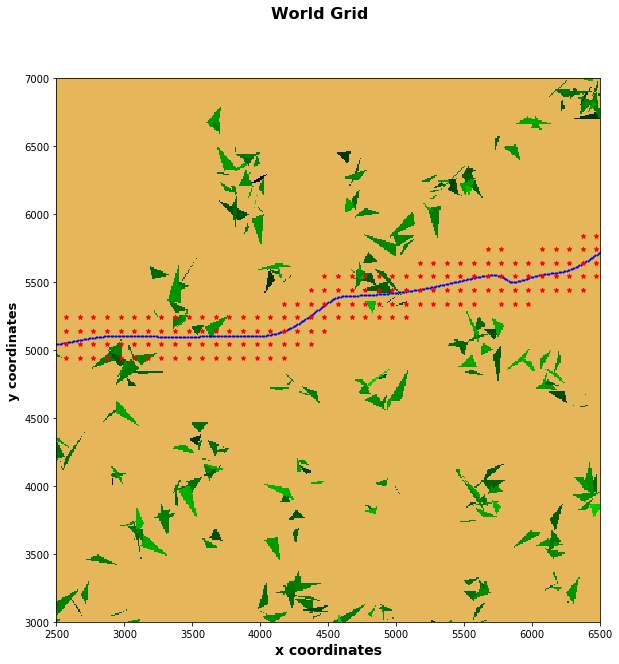

In [45]:

plot_map([X_route, Y_route], [X_inlimit, Y_inlimit], size=(10, 10), zoom=(4500, 5000))

### Select the  images from the route and Plot their Headings

In [0]:
#find the U and V of the route images which are located within the world grid images limit
U_route = []
V_route = []

for i in range(0,len(Heading_route)):
    U_route.append(pol2cart(Heading_route[i],1)[0])
    V_route.append(pol2cart(Heading_route[i],1)[1])

(3950, 6050)

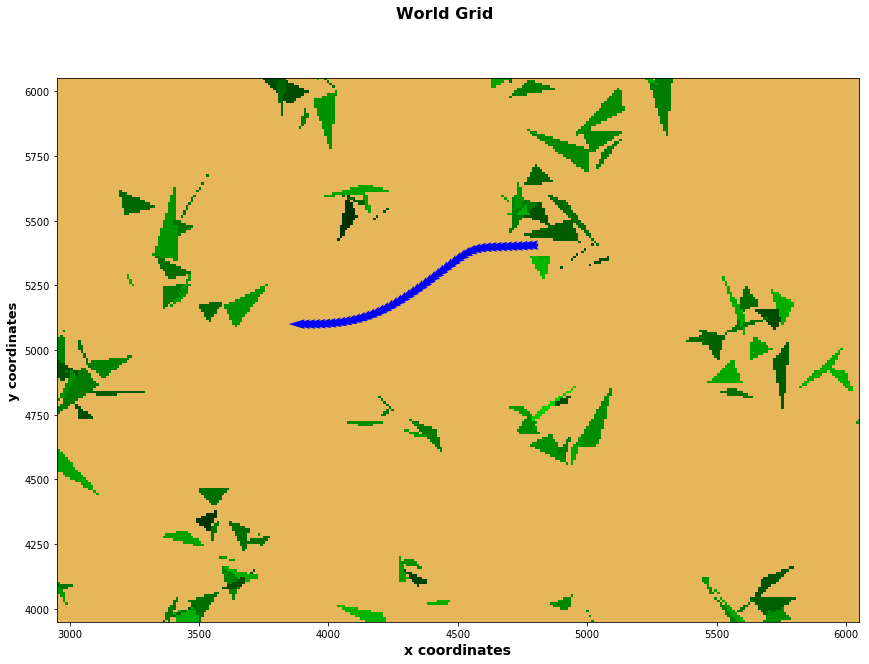

In [0]:
first = 400
last = 500

X_route_inlimit10, Y_route_inlimit10, Heading_route_inlimit10, route_images10 = sample_from_route(last, first, 2)

#find the U and V of the route images which are located within the world grid images limit
U_route_inlimit10, V_route_inlimit10 = pol_2cart_headings(Heading_route_inlimit10)


fig =  plt.figure(figsize=(15,10))
fig.suptitle('World Grid', fontsize=16,fontweight='bold')
plt.xlabel('x coordinates',fontsize=14,fontweight='bold')
plt.ylabel('y coordinates',fontsize=13,fontweight='bold')
plt.quiver(X_route_inlimit10,Y_route_inlimit10,U_route_inlimit10 ,V_route_inlimit10, scale=50, color='blue')
plt.imshow(world, zorder=0, extent=[-0.158586*1000 , 10.2428*1000, -0.227704*1000, 10.0896*1000])
plt.xlim([2701-50, 7701+50])
plt.ylim([2659-50, 7659+50])
plt.xlim([3000-50, 6000+50])
plt.ylim([4000-50, 6000+50])




## Select the world grid images which are close to the route images

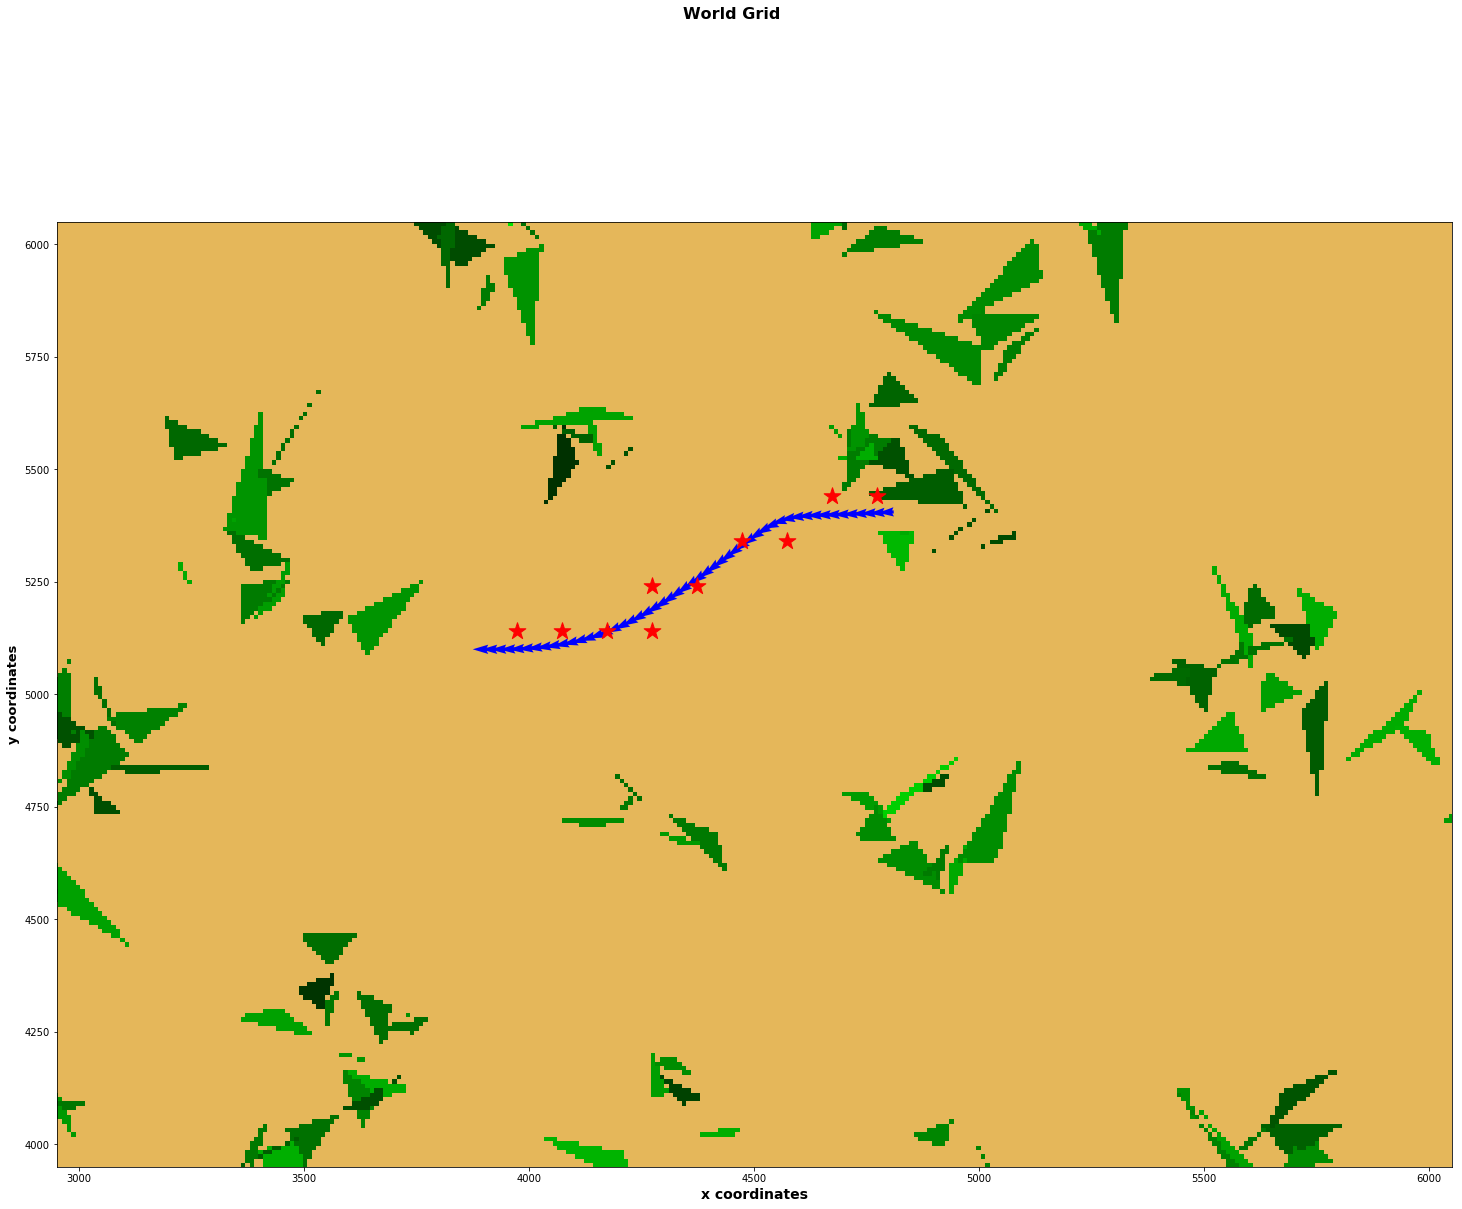

In [0]:
X_inlimit10 = []
Y_inlimit10 = []
world_grid_imgs10 = []



for i in range(0,len(X_inlimit),1):
    dist=[]
    for j in range(0,len(X_route_inlimit10),1):
        d = (math.sqrt((X_route_inlimit10[j] - X_inlimit[i])**2 + (Y_route_inlimit10[j] - Y_inlimit[i])**2))
        dist.append(d)
    if(min(dist)<50):
        X_inlimit10.append(X_inlimit[i])
        Y_inlimit10.append(Y_inlimit[i])
        world_grid_imgs10.append(world_grid_imgs[i])
        

fig =  plt.figure(figsize=(25,20))
fig.suptitle('World Grid', fontsize=16,fontweight='bold')
plt.xlabel('x coordinates',fontsize=14,fontweight='bold')
plt.ylabel('y coordinates',fontsize=13,fontweight='bold')
#plt.scatter(X_route_inlimit10,Y_route_inlimit10 , marker="o",s=30,color='blue')

plt.quiver(X_route_inlimit10,Y_route_inlimit10,U_route_inlimit10,V_route_inlimit10, scale=90, color='b')

plt.scatter(X_inlimit10,Y_inlimit10,marker="*", s=310,color='red')
#plt.scatter(X_inlimit10[31],Y_inlimit10[31],marker="*", s=3000,color='red')
plt.imshow(world, zorder=0, extent=[-0.158586*1000 , 10.2428*1000, -0.227704*1000, 10.0896*1000])
plt.xlim([2701-50, 7701+50])
plt.ylim([2659-50, 7659+50])
plt.xlim([3000-50, 6000+50])
plt.ylim([4000-50, 6000+50])


fig.savefig('graph1.jpg')




## Perfect Memory with RMSE

In [0]:
def ridf(ref_img, current_img,  degrees, step):
  RMSE = [] # Hold the RMSEs between the current and the image of the route for every degree
  for k in range (0, degrees, step):
    curr_image = rotate(k,current_image)    #Rotate the current image
    RMSE.append(rmse(curr_image,ref_image))  #IDF function to find the error between the selected route image and the rotated current
  return RMSE

In [0]:
def perfect_memory(w_g_imgs,on_route_images) :   
  degree_shift = 1
  IDF_error = []
  Recovered_Heading = []

  for i in range (0,len(w_g_imgs),1): # For every world grid image
      current_image = w_g_imgs[i]     #set the current image

      RMS_For_Goal_Image = []                 #Hold the RMS between the current image and print(len(world_grid_imgs10))the different route images
      Headings_For_Goal_image = []            #Hold the recovered Headings for the current image by the different route images


      for j in range (0,len(on_route_images),1): #For every goal Image

          goal_image = on_route_images[j]        #Set the goal Image
          RMS = [] # Hold the RMS between the current and the image of the route for every degree
          Degrees = [] # Hold the degrees
          
          for k in range (0,360,degree_shift):
              curr_image = rotate(k,current_image)    #Rotate the current image
              RMS.append(idf(curr_image,goal_image))  #IDF function to find the error between the selected route image and the rotated current
              Degrees.append(k)                       #Degrees


          RMS_For_Goal_Image.append(min(RMS))
          Headings_For_Goal_image.append(Degrees[RMS.index(min(RMS))])


      IDF_error.append(min(RMS_For_Goal_Image))
      Recovered_Heading.append(Headings_For_Goal_image[RMS_For_Goal_Image.index(min(RMS_For_Goal_Image))])

  return IDF_error, Recovered_Heading


In [0]:
IDF_error, Recovered_Heading = perfect_memory(world_grid_imgs10,route_images10)

### Convert the recovered Headings from Cartesian to pol 

In [0]:
    
U_inlimit10, V_inlimit10 = pol_2cart_headings(Recovered_Heading)

### In the next cell you can select a specific world grid image and see where is located as well as its recovered heading

coordinates:
4072.3
5141.41
Recovered Heading:
190


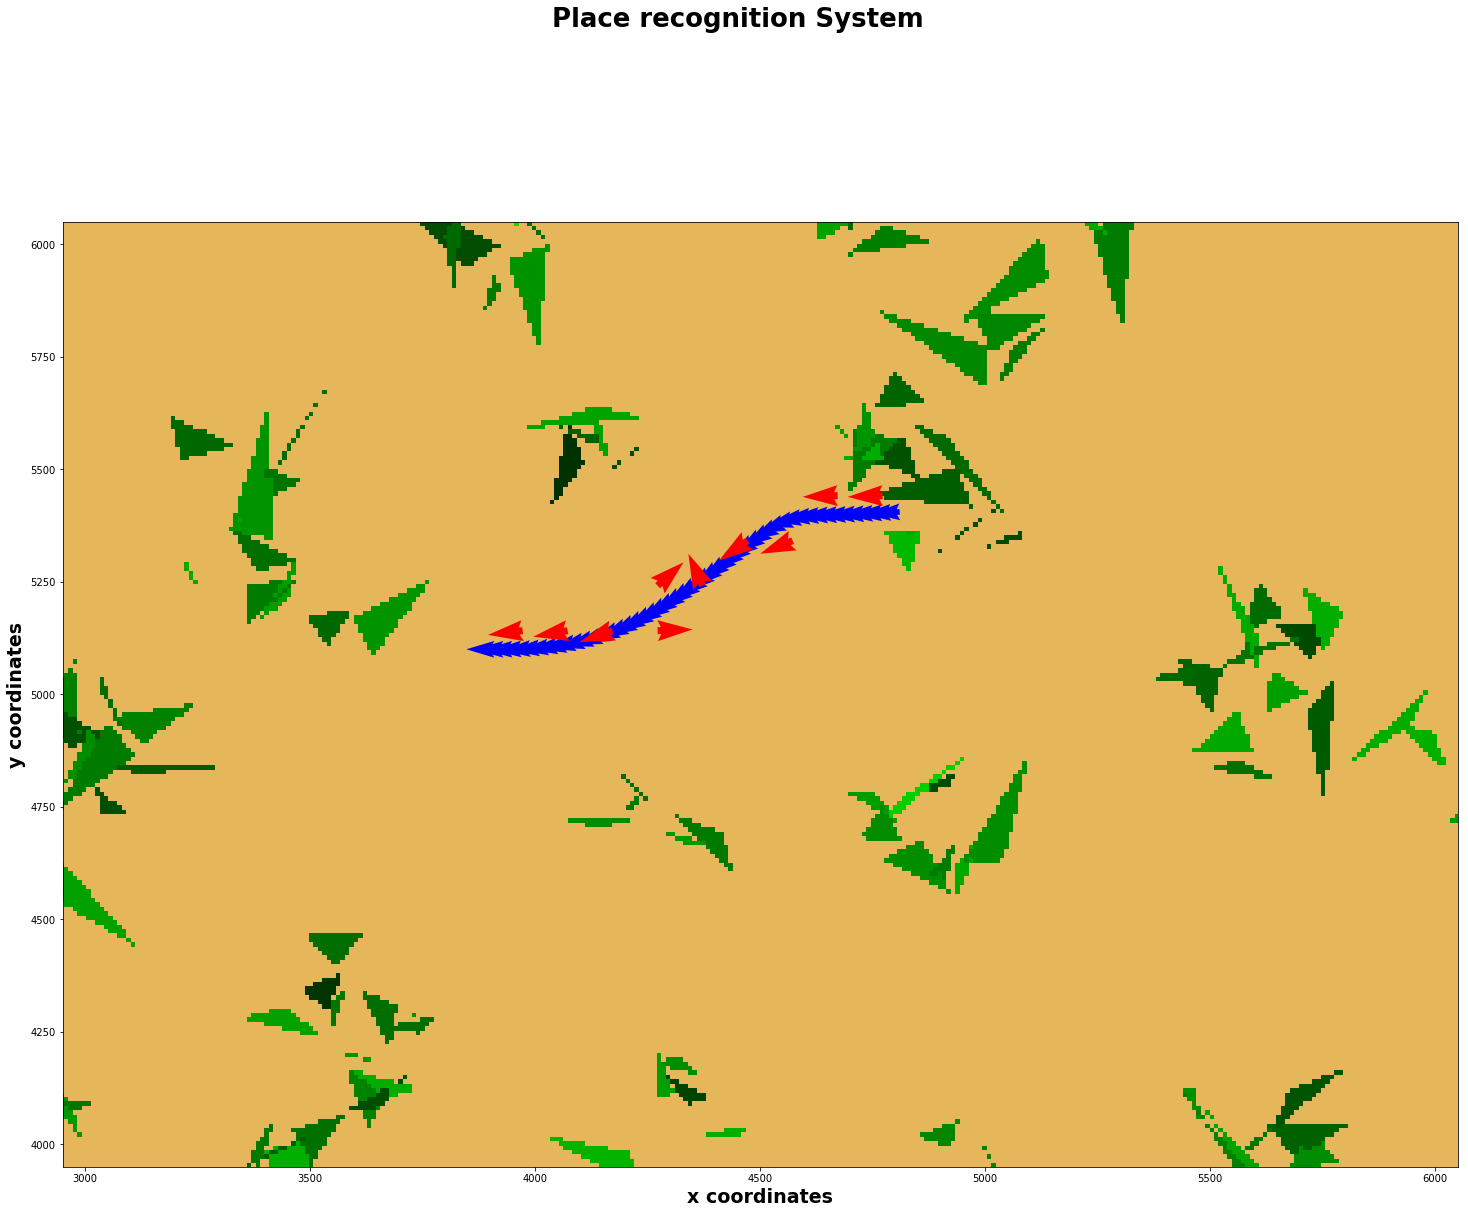

In [0]:
t = 1

fig =  plt.figure(figsize=(25,20))
fig.suptitle('Place recognition System', fontsize=26,fontweight='bold')
plt.xlabel('x coordinates',fontsize=19,fontweight='bold')
plt.ylabel('y coordinates',fontsize=19,fontweight='bold')
#plt.scatter(X_route_inlimit10,Y_route_inlimit10 , marker="o",s=30,color='blue')

plt.quiver(X_route_inlimit10,Y_route_inlimit10,U_route_inlimit10,V_route_inlimit10, scale=50, color='b')

#plt.scatter(X_inlimit10,Y_inlimit10,marker="*", s=20,color='red')
plt.quiver(X_inlimit10,Y_inlimit10,U_inlimit10,V_inlimit10, scale=40, color='red')
plt.imshow(world, zorder=0, extent=[-0.158586*1000 , 10.2428*1000, -0.227704*1000, 10.0896*1000])


plt.xlim([3000-50, 6000+50])
plt.ylim([4000-50, 6000+50])
fig.savefig('perfectMemory.jpg')

print("coordinates:")
print(X_inlimit10[t])
print(Y_inlimit10[t])
print("Recovered Heading:")
print(Recovered_Heading[t])



# Investigate the headings that go off-route

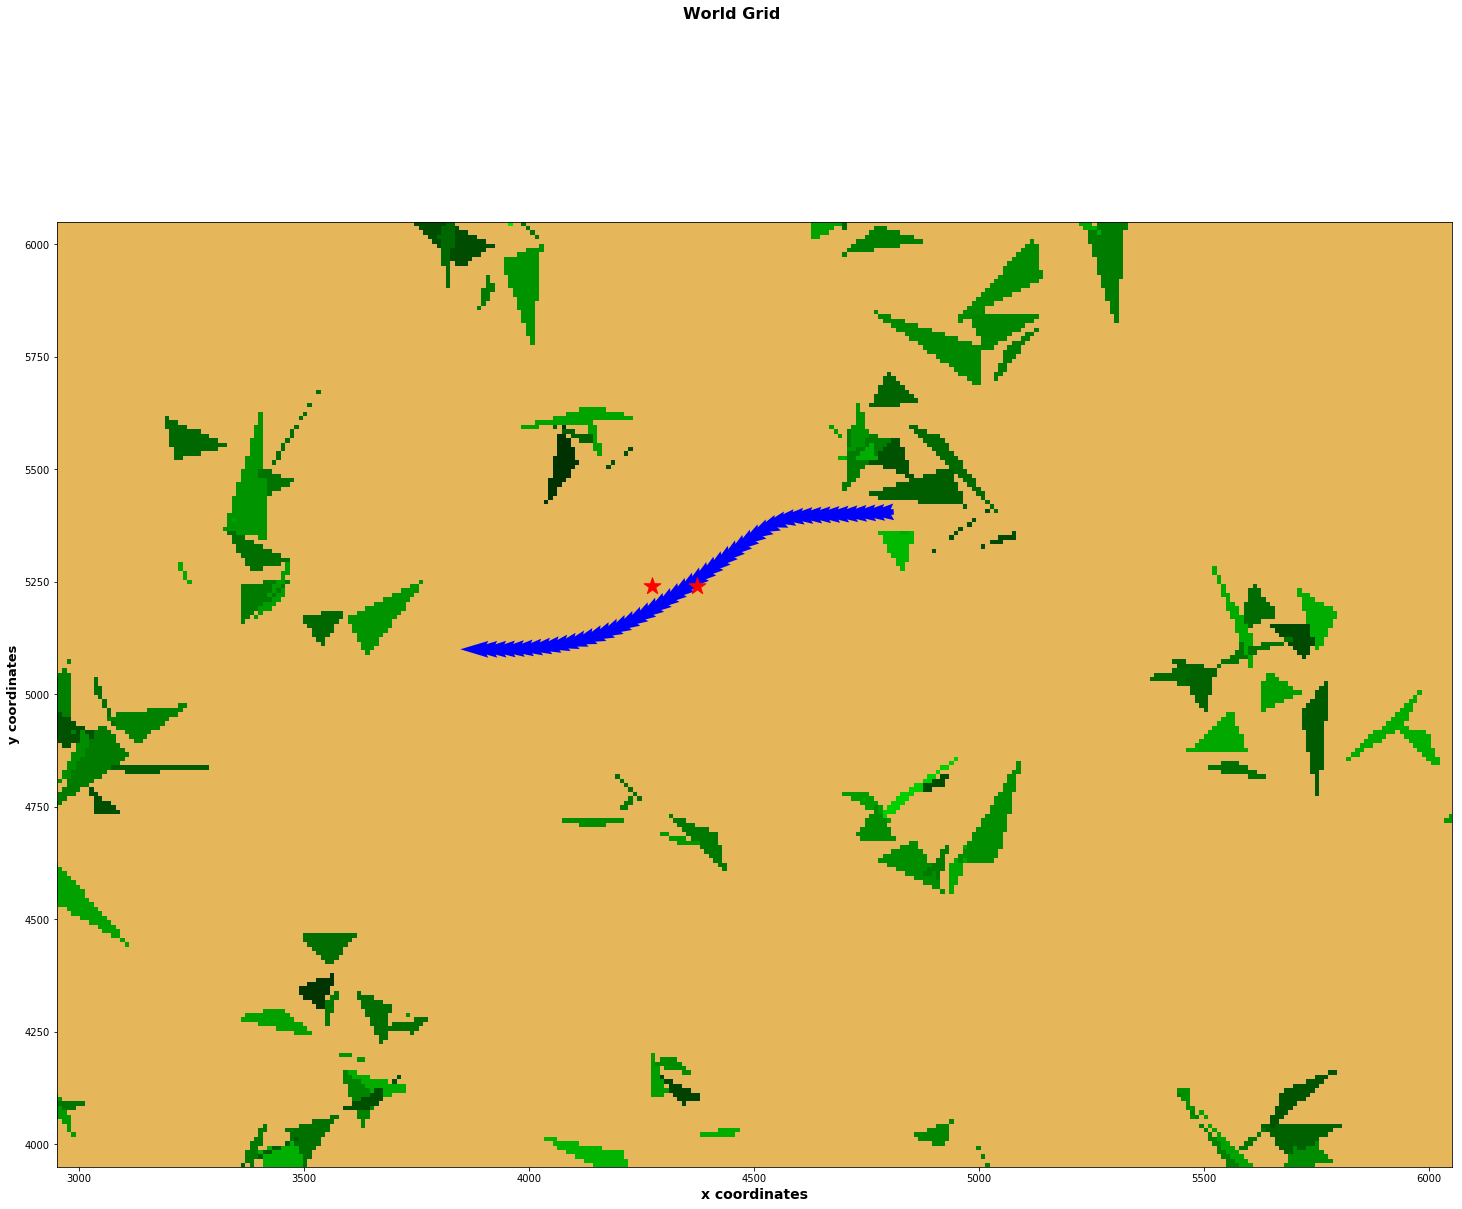

In [0]:

wgi_test = world_grid_imgs10[4:6]
X_test = X_inlimit10[4:6]
Y_test = Y_inlimit10[4:6]



fig =  plt.figure(figsize=(25,20))
fig.suptitle('World Grid', fontsize=16,fontweight='bold')
plt.xlabel('x coordinates',fontsize=14,fontweight='bold')
plt.ylabel('y coordinates',fontsize=13,fontweight='bold')
#plt.scatter(X_route_inlimit10,Y_route_inlimit10 , marker="o",s=30,color='blue')

plt.quiver(X_route_inlimit10,Y_route_inlimit10,U_route_inlimit10,V_route_inlimit10, scale=50, color='b')

plt.scatter(X_test,Y_test,marker="*", s=310,color='red')
#plt.scatter(X_inlimit10[31],Y_inlimit10[31],marker="*", s=3000,color='red')
plt.imshow(world, zorder=0, extent=[-0.158586*1000 , 10.2428*1000, -0.227704*1000, 10.0896*1000])
plt.xlim([2701-50, 7701+50])
plt.ylim([2659-50, 7659+50])
plt.xlim([3000-50, 6000+50])
plt.ylim([4000-50, 6000+50])


fig.savefig('graph_test.jpg')

(3950, 6050)

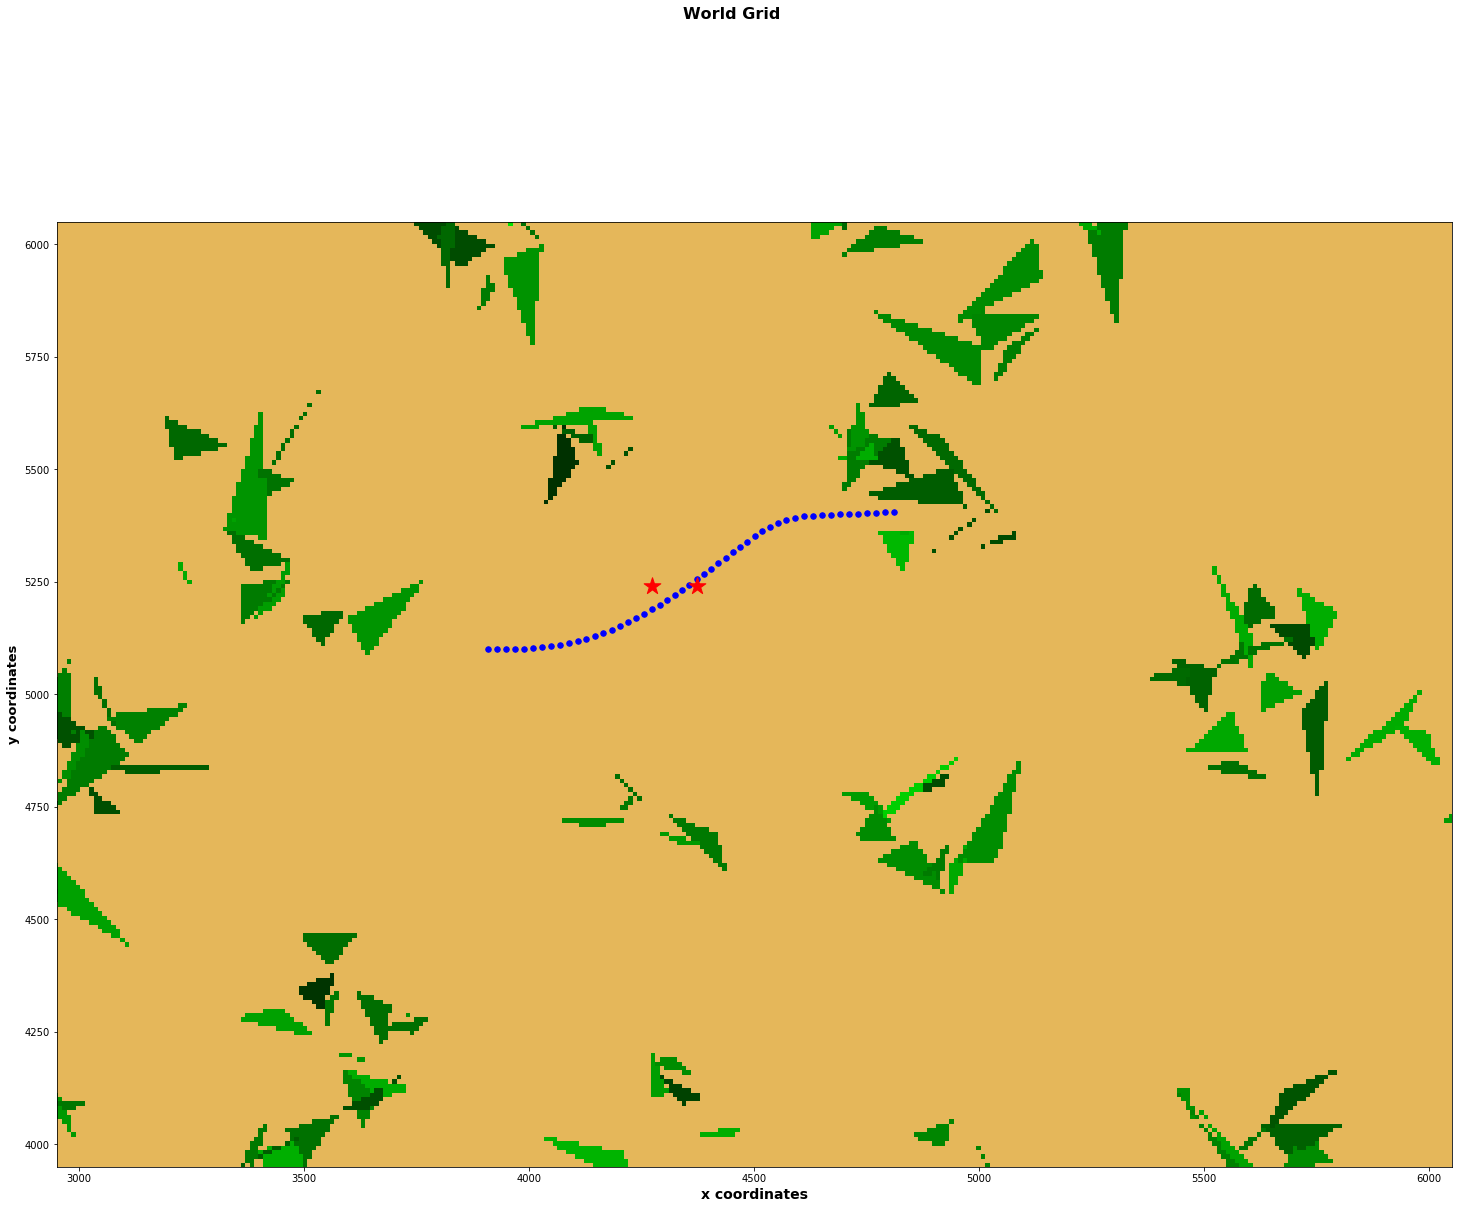

In [0]:

X_route_inlimit, Y_route_inlimit, Heading_route_inlimit, route_images_in_limit = sample_from_route(430, 480, 2)


       

fig =  plt.figure(figsize=(25,20))
fig.suptitle('World Grid', fontsize=16,fontweight='bold')
plt.xlabel('x coordinates',fontsize=14,fontweight='bold')
plt.ylabel('y coordinates',fontsize=13,fontweight='bold')
plt.scatter(X_route_inlimit10,Y_route_inlimit10 , marker="o",s=30,color='blue')

#plt.quiver(X_route_inlimit, Y_route_inlimit, U_route_inlimit, V_route_inlimit, scale=50, color='b')

plt.scatter(X_test,Y_test,marker="*", s=310,color='red')
#plt.scatter(X_inlimit10[31],Y_inlimit10[31],marker="*", s=3000,color='red')
plt.imshow(world, zorder=0, extent=[-0.158586*1000 , 10.2428*1000, -0.227704*1000, 10.0896*1000])
plt.xlim([2701-50, 7701+50])
plt.ylim([2659-50, 7659+50])
plt.xlim([3000-50, 6000+50])
plt.ylim([4000-50, 6000+50])


In [0]:
IDF_error, Recovered_Heading = perfect_memory(wgi_test,route_images10)

coordinates:
4072.3
5141.41
Recovered Heading:
116


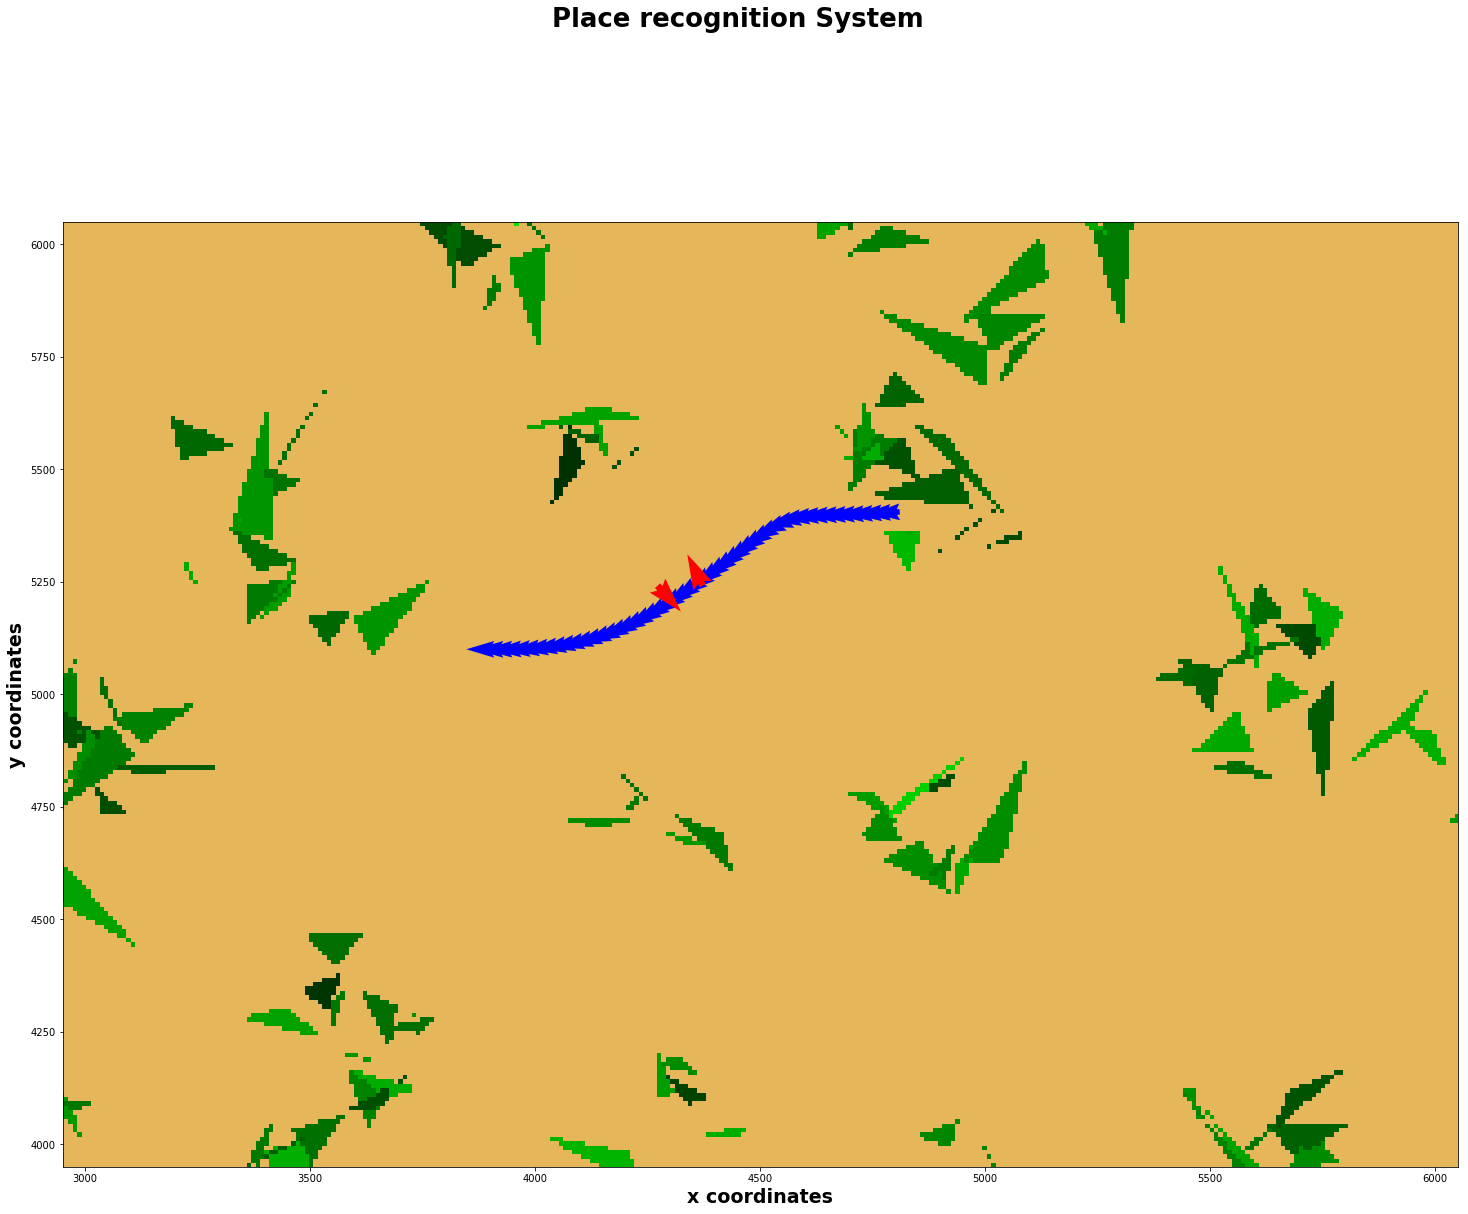

In [0]:
U_test, V_test = pol_2cart_headings(Recovered_Heading)


t = 1

fig =  plt.figure(figsize=(25,20))
fig.suptitle('Place recognition System', fontsize=26,fontweight='bold')
plt.xlabel('x coordinates',fontsize=19,fontweight='bold')
plt.ylabel('y coordinates',fontsize=19,fontweight='bold')
#plt.scatter(X_route_inlimit10,Y_route_inlimit10 , marker="o",s=30,color='blue')

plt.quiver(X_route_inlimit10,Y_route_inlimit10,U_route_inlimit10,V_route_inlimit10, scale=50, color='b')

#plt.scatter(X_inlimit10,Y_inlimit10,marker="*", s=20,color='red')
plt.quiver(X_test,Y_test,U_test,V_test, scale=40, color='red')
plt.imshow(world, zorder=0, extent=[-0.158586*1000 , 10.2428*1000, -0.227704*1000, 10.0896*1000])


plt.xlim([3000-50, 6000+50])
plt.ylim([4000-50, 6000+50])
fig.savefig('perfectMemory.jpg')

print("coordinates:")
print(X_inlimit10[t])
print(Y_inlimit10[t])
print("Recovered Heading:")
print(Recovered_Heading[t])

## Perfect Memory with SSIM

In [0]:
def perfect_memory_ssim(w_g_imgs,on_route_images) :   
  degree_shift = 1
  IDF_error = []
  Recovered_Heading = []

  for i in range (0,len(w_g_imgs),1): # For every world grid image
      current_image = w_g_imgs[i]     #set the current image

      RMS_For_Goal_Image = []                 #Hold the RMS between the current image and print(len(world_grid_imgs10))the different route images
      Headings_For_Goal_image = []            #Hold the recovered Headings for the current image by the different route images


      for j in range (0,len(on_route_images),1): #For every goal Image

          goal_image = on_route_images[j]        #Set the goal Image
          RMS = [] # Hold the RMS between the current and the image of the route for every degree
          Degrees = [] # Hold the degrees
          
          for k in range (0,360,degree_shift):
              curr_image = rotate(k,current_image)    #Rotate the current image
              RMS.append(ssim(curr_image,goal_image))  #IDF function to find the error between the selected route image and the rotated current
              Degrees.append(k)                       #Degrees


          RMS_For_Goal_Image.append(max(RMS))
          Headings_For_Goal_image.append(Degrees[RMS.index(max(RMS))])

    
      IDF_error.append(max(RMS_For_Goal_Image))
      Recovered_Heading.append(Headings_For_Goal_image[RMS_For_Goal_Image.index(max(RMS_For_Goal_Image))])
      

  return IDF_error, Recovered_Heading

IDF_error, Recovered_Heading = perfect_memory_ssim(world_grid_imgs10,route_images10)

### Convert the recovered Headings from Cartesian to pol 

In [0]:
U_inlimit10 = []
V_inlimit10 = []

for i in range (0,len(Recovered_Heading)):
    U_inlimit10.append(pol2cart(Recovered_Heading[i],1)[0])
    V_inlimit10.append(pol2cart(Recovered_Heading[i],1)[1])

coordinates:
4072.3
5141.41
Recovered Heading:
190


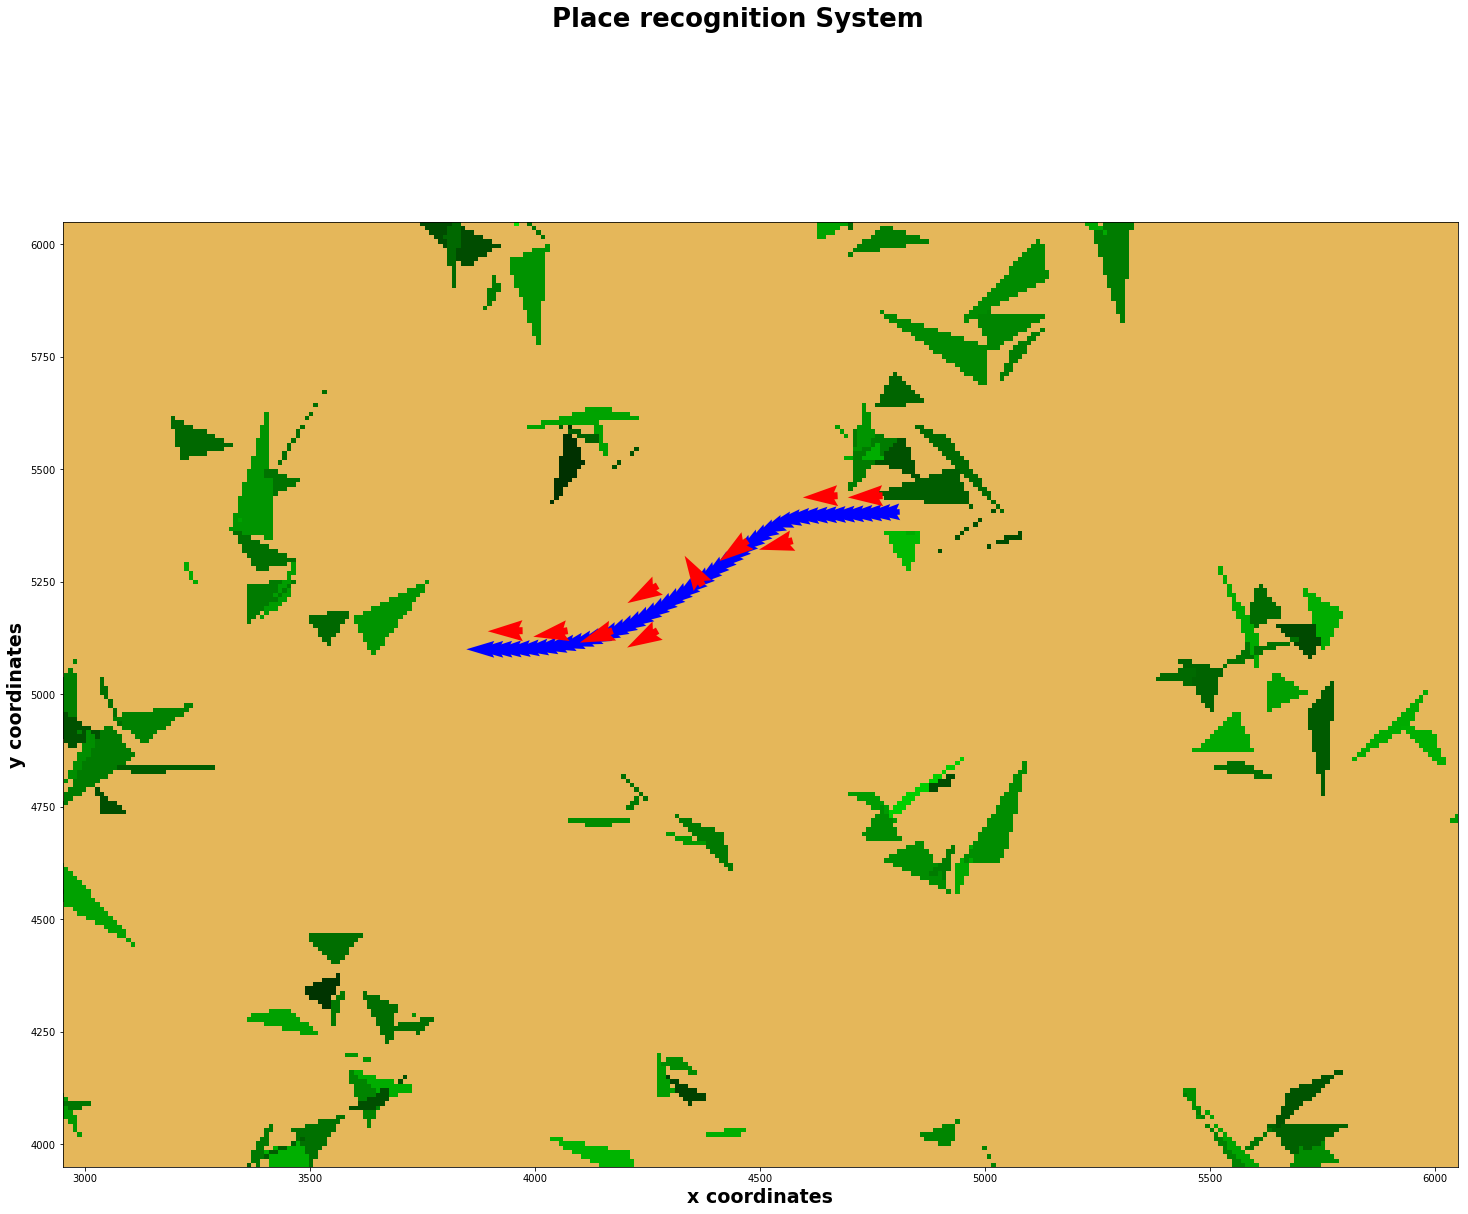

In [0]:
t = 1

fig =  plt.figure(figsize=(25,20))
fig.suptitle('Place recognition System', fontsize=26,fontweight='bold')
plt.xlabel('x coordinates',fontsize=19,fontweight='bold')
plt.ylabel('y coordinates',fontsize=19,fontweight='bold')
#plt.scatter(X_route_inlimit10,Y_route_inlimit10 , marker="o",s=30,color='blue')

plt.quiver(X_route_inlimit10,Y_route_inlimit10,U_route_inlimit10,V_route_inlimit10, scale=50, color='b')

#plt.scatter(X_inlimit10,Y_inlimit10,marker="*", s=20,color='red')
plt.quiver(X_inlimit10,Y_inlimit10,U_inlimit10,V_inlimit10, scale=40, color='red')
plt.imshow(world, zorder=0, extent=[-0.158586*1000 , 10.2428*1000, -0.227704*1000, 10.0896*1000])


plt.xlim([3000-50, 6000+50])
plt.ylim([4000-50, 6000+50])
fig.savefig('perfectMemory.jpg')

print("coordinates:")
print(X_inlimit10[t])
print(Y_inlimit10[t])
print("Recovered Heading:")
print(Recovered_Heading[t])


## Perfect Memory test with pre-processing.

In [0]:
pre_world_grid_imgs10 = pre_process(world_grid_imgs10, (180, 36))
pre_route_images10 = pre_process(route_images10, (180, 36))

In [0]:
IDF_error, Recovered_Heading = perfect_memory(pre_world_grid_imgs10,pre_route_images10)

### Convert the recovered Headings from Cartesian to pol 

In [0]:
U_inlimit10 = []
V_inlimit10 = []

for i in range (0,len(Recovered_Heading)):
    U_inlimit10.append(pol2cart(Recovered_Heading[i],1)[0])
    V_inlimit10.append(pol2cart(Recovered_Heading[i],1)[1])

coordinates:
4072.3
5141.41
Recovered Heading:
190


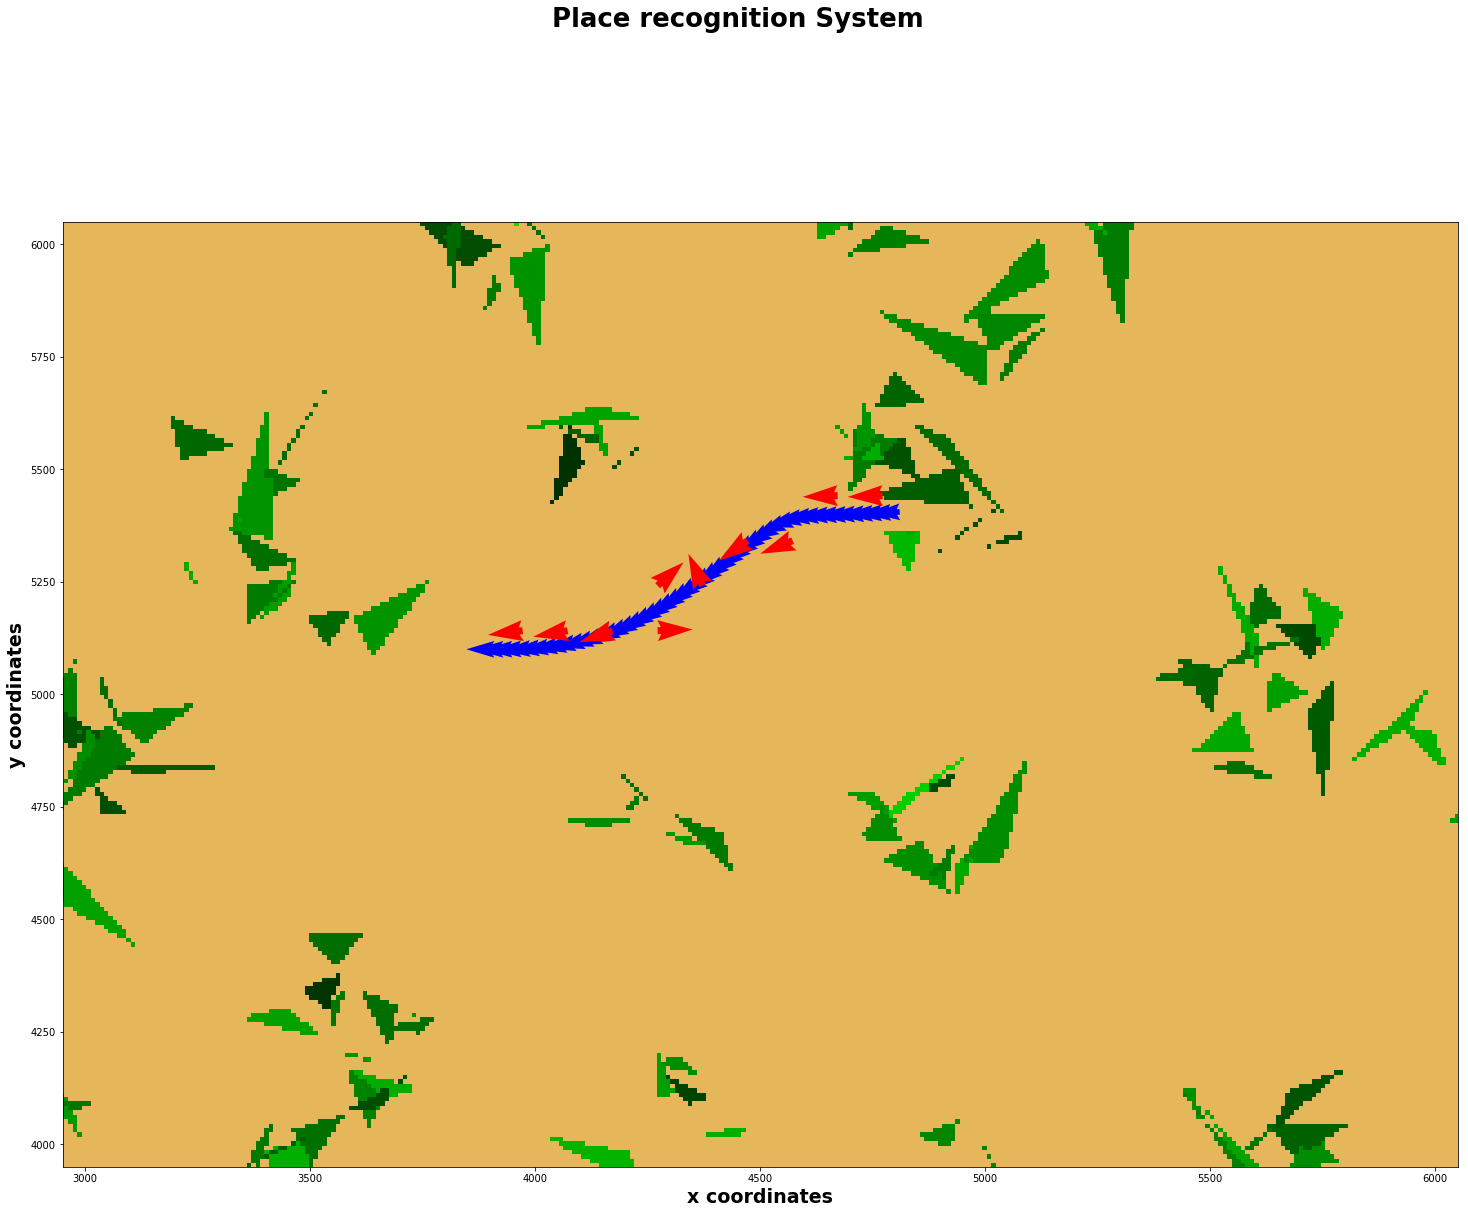

In [0]:
t = 1

fig =  plt.figure(figsize=(25,20))
fig.suptitle('Place recognition System', fontsize=26,fontweight='bold')
plt.xlabel('x coordinates',fontsize=19,fontweight='bold')
plt.ylabel('y coordinates',fontsize=19,fontweight='bold')
#plt.scatter(X_route_inlimit10,Y_route_inlimit10 , marker="o",s=30,color='blue')

plt.quiver(X_route_inlimit10,Y_route_inlimit10,U_route_inlimit10,V_route_inlimit10, scale=50, color='b')

#plt.scatter(X_inlimit10,Y_inlimit10,marker="*", s=20,color='red')
plt.quiver(X_inlimit10,Y_inlimit10,U_inlimit10,V_inlimit10, scale=40, color='red')
plt.imshow(world, zorder=0, extent=[-0.158586*1000 , 10.2428*1000, -0.227704*1000, 10.0896*1000])


plt.xlim([3000-50, 6000+50])
plt.ylim([4000-50, 6000+50])
fig.savefig('perfectMemory.jpg')

print("coordinates:")
print(X_inlimit10[t])
print(Y_inlimit10[t])
print("Recovered Heading:")
print(Recovered_Heading[t])


In [0]:

filters = 4  # The base filter number
kernel_size = [5, 5]
stride=2
padding='same'
out_activ_func = tf.nn.sigmoid
activ_func = tf.nn.relu
hidden_shape = None
hidden_units = None
n_z = 5000
input_shape = (200, 200)
resize_method = tf.image.ResizeMethod.NEAREST_NEIGHBOR

def tf_img_resize(img):
        return tf.image.resize_images(img, size=list(input_shape), method=resize_method)



images = tfk.Input(dtype=tf.float32, shape=input_shape + (1,), name="Images")
print("Shape of input layer -> {}".format(images))
net = tfkl.Conv2D(filters, activation=activ_func, kernel_size=kernel_size, strides=stride,
                           padding=padding, name="enc_1")(images)
print("Shape of 1st layer -> {}".format(net))

net = tfkl.Conv2D(filters*2, activation=activ_func, kernel_size=kernel_size, strides=stride,
                            padding=padding, name="enc_2")(net)
print("Shape of 2nd layer -> {}".format(net))

net = tfkl.Conv2D(filters*4, activation=activ_func, kernel_size=kernel_size, strides=stride,
                            padding=padding, name="enc_3")(net)
print("Shape of 3rd layer -> {}".format(net))

# Get number of units and shape in last conv hidden layer before flattening
hidden_shape = tf.shape(net)
hidden_units = np.prod(net.get_shape().as_list()[1:])
net_flat = tfkl.Flatten(name="net_flat")(net)

z = tfkl.Dense(units=n_z, name='z', activation=activ_func)(net_flat)


net_flat = tfkl.Dense(hidden_units, activation=activ_func, name="upscale")(z)
# Shape back to original shape of the last covn layer
net = tfkl.Lambda(lambda flat: tfkb.reshape(flat, hidden_shape))(net_flat)

# net = tfkl.Conv2DTranspose(filters*4, activation=activ_func, kernel_size=kernel_size,
#                                  strides=stride, padding=padding, name="dec_0")(net)
# print("Shape of 5th layer -> {}".format(net))

net = tfkl.Conv2DTranspose(filters*2, activation=activ_func, kernel_size=kernel_size,
                           padding=padding, strides=stride, name="dec_1")(net)
print("Shape of 6th layer -> {}".format(net))

net = tfkl.Conv2DTranspose(filters, activation=activ_func, kernel_size=kernel_size,
                           padding=padding, strides=stride, name="dec_2")(net)
print("Shape of 7th layer -> {}".format(net))

net = tfkl.Conv2DTranspose(1, activation=out_activ_func, kernel_size=kernel_size,
                           padding=padding, strides=stride, name="dec_3")(net)
print("Shape of 8th layer -> {}".format(net))

# Reshape up-sampled image to match the original image input
out = tfkl.Lambda(tf_img_resize)(net)
# net = tfkb.resize_images(net, 200, 200, 'channels_last', interpolation='nearest')

Shape of input layer -> Tensor("Images_9:0", shape=(?, 200, 200, 1), dtype=float32)
Shape of 1st layer -> Tensor("enc_1_8/Relu:0", shape=(?, 100, 100, 4), dtype=float32)
Shape of 2nd layer -> Tensor("enc_2_8/Relu:0", shape=(?, 50, 50, 8), dtype=float32)
Shape of 3rd layer -> Tensor("enc_3_8/Relu:0", shape=(?, 25, 25, 16), dtype=float32)
Shape of 6th layer -> Tensor("dec_1_4/Relu:0", shape=(?, 50, 50, 8), dtype=float32)
Shape of 7th layer -> Tensor("dec_2_4/Relu:0", shape=(?, 100, 100, 4), dtype=float32)
Shape of 8th layer -> Tensor("dec_3_4/Sigmoid:0", shape=(?, 200, 200, 1), dtype=float32)


In [0]:
CAE = tf.keras.Model(inputs=images, outputs=out)

def recon_loss(y, pred):
  return tf.losses.mean_squared_error(y, pred)

CAE.compile(optimizer=tf.train.RMSPropOptimizer(0.001),
              loss='mse',
              metrics=['acc', 'mse'])

Instructions for updating:
Use tf.cast instead.


(795, 150, 720)
(795, 200, 200)
(795, 200, 200, 1)


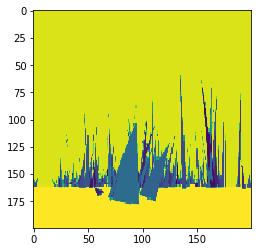

In [0]:
sample_route_images = np.array(route_images)
print(sample_route_images.shape)
sample_route_images = np.array([cv2.resize(img, dsize=(200, 200), interpolation=cv2.INTER_NEAREST) for img in sample_route_images])
print(sample_route_images.shape)
sample_route_images = np.expand_dims(sample_route_images, axis=3)
print(sample_route_images.shape)

plt.imshow(np.squeeze(sample_route_images[0]))

#plt.imshow(np.squeeze(sample_route_images[0]))

In [0]:
logs = CAE.fit(sample_route_images, sample_route_images, batch_size=50, epochs=20)

Epoch 1/20
795/795 [==============================] - 1s 1ms/sample - loss: 27821.8298 - acc: 0.0000e+00 - mean_squared_error: 27821.8281
Epoch 2/20
795/795 [==============================] - 1s 957us/sample - loss: 27821.8295 - acc: 0.0000e+00 - mean_squared_error: 27821.8320
Epoch 3/20
795/795 [==============================] - 1s 930us/sample - loss: 27821.8300 - acc: 0.0000e+00 - mean_squared_error: 27821.8281
Epoch 4/20
795/795 [==============================] - 1s 921us/sample - loss: 27821.8299 - acc: 0.0000e+00 - mean_squared_error: 27821.8281
Epoch 5/20
795/795 [==============================] - 1s 918us/sample - loss: 27821.8304 - acc: 0.0000e+00 - mean_squared_error: 27821.8320
Epoch 6/20
795/795 [==============================] - 1s 917us/sample - loss: 27821.8297 - acc: 0.0000e+00 - mean_squared_error: 27821.8320
Epoch 7/20
795/795 [==============================] - 1s 927us/sample - loss: 27821.8300 - acc: 0.0000e+00 - mean_squared_error: 27821.8340
Epoch 8/20
795/795 [==

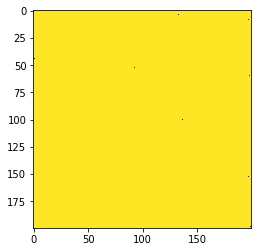

In [0]:
img = np.expand_dims(sample_route_images[0], axis=0)
pred_img = CAE.predict(img)

plt.imshow(np.squeeze(pred_img))

### Error Calculation Perfect Memory

For every world grid image find the closest route image and compare their headings. Find the average absolute value between the headings for all the world grid images. This will be the average error of the model

In [0]:
k = [] # Holds the position of the closest picture
error = [] # Holds the error between the world grid image and the closest route imageroute
for i in range (0,len(X_inlimit10)):
    distance = []
    for j in range (0,len(X_route_inlimit10)):
        d = math.sqrt((X_inlimit10[i]-X_route_inlimit10[j])**2+((Y_inlimit10[i]-Y_route_inlimit10[j])**2))
        distance.append(d)
    
    k.append(distance.index(min(distance)))
    error.append(abs(Recovered_Heading[i]- Heading_route_inlimit10[distance.index(min(distance))]))
    
    
        
        

### Calculate the average error of the model

In [0]:
sum = 0
for i in range (0,len(error)):
    sum = sum + error [i]
average_error = sum / len(error)
print(average_error)

0.6809285714285725


### Calculate the median error of the model

In [0]:
from numpy import median
median_error = median(error)
median_error

0.6855000000000047